# DIgital Pathology WSI loader

# Patch Inferer

![](https://raw.githubusercontent.com/Project-MONAI/tutorials/87792475f4476dcc63f92e47e109dde18cdfb30d/figures/patch_inferer.jpg)

### Setup imports

In [3]:
import os

import torch
import zarr
from matplotlib import pyplot as plt
from monai.apps import download_url
from monai.config import print_config
from monai.data import Dataset, DataLoader, PILReader, WSIReader
from monai.inferers import AvgMerger, PatchInferer, SlidingWindowSplitter, WSISlidingWindowSplitter, ZarrAvgMerger
from monai.transforms import LoadImage, Compose, EnsureChannelFirst, AsChannelLast

print_config()

MONAI version: 1.3.dev2334
Numpy version: 1.22.2
Pytorch version: 1.14.0a0+44dac51
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c5771c7316c8b024071ecd7135d77ae70bcd557e
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.7.1
TorchVision version: 0.15.0a0
tqdm version: 4.64.1
lmdb version: 1.4.1
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.6.0
pynrrd version: 1.0.0
clearml version: 1.12.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Environment variable `TORCH_ALLOW_TF32_CUBLAS_OVERRIDE = 1` is set.
  This environment variable may enable TF32 mode accidentally and affect precision.
  See https://docs.monai.io/en/latest/precision_accelerating.html#precision-and-accelerating


### Auxiliary functions

In [4]:
def plot_limit_axis(ax, img, xlim, ylim):
    ax.imshow(AsChannelLast()(img[0]).to(torch.uint8))
    ax.set_xlim([0, xlim])
    ax.set_ylim([ylim, 0])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])


def network_random_brightness(img):
    return img * (torch.rand(1) + 1) * 0.5


def run_inference(inferer, network, filenames, transform=None):
    dataset = Dataset(filenames, transform=transform)
    outputs = []
    for inputs in DataLoader(dataset):
        out = inferer(inputs, network)
        outputs.append(out)
    return outputs

### Sliding Window Patch Inference
Inference of images by splitting them into patches using sliding window and merging the patches to build the inference result for the entire image.
[PatchInferer](https://docs.monai.io/en/stable/inferers.html#patchinferer)

In [5]:
# Plot aux function
def cat_plot(ax, img):
    plot_limit_axis(ax, img, 512, 640)


# Download the image and create file path list
IMAGE_URLS = ["https://github.com/Project-MONAI/MONAI/raw/dev/tests/testing_data/kitty_test.jpg"]
IMAGE_PATH_LIST = []
for url in IMAGE_URLS:
    path = os.path.join(os.path.abspath("."), os.path.basename(url))
    download_url(url, path)
    IMAGE_PATH_LIST.append(path)

# Transforms
transforms = Compose([LoadImage(reader=PILReader, reverse_indexing=False, image_only=True), EnsureChannelFirst()])

# Load input image (for plotting purposes only)
IMAGE = transforms(IMAGE_PATH_LIST)

2023-08-23 05:39:20,580 - INFO - Expected md5 is None, skip md5 check for file /workspace/notebook_monai/kitty_test.jpg.
2023-08-23 05:39:20,581 - INFO - File exists: /workspace/notebook_monai/kitty_test.jpg, skipped downloading.


![kitty_test.jpg](kitty_test.jpg)

## Effect of overlap

Text(0.5, 0.98, 'Effect of overlap (without padding, patch_size=64)')

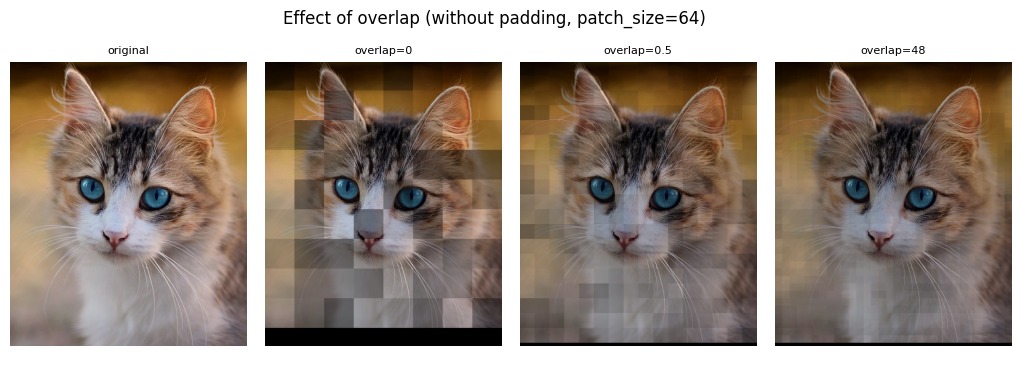

In [ ]:
patch_size = 64
overlaps = [0, 0.5, 48]
nrows = 1
ncols = len(overlaps) + 1
figsize = (3 * ncols + 1, 4 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, top=0.85)
cat_plot(axes[0], IMAGE)
axes[0].set_title("original", fontsize=8)
for i, overlap in enumerate(overlaps, 1):
    inferer = PatchInferer(
        splitter=SlidingWindowSplitter(patch_size=patch_size, overlap=overlap, pad_mode=None),
        merger_cls=AvgMerger,
        match_spatial_shape=False,
    )
    img = run_inference(inferer, network_random_brightness, IMAGE_PATH_LIST, transforms)
    cat_plot(axes[i], img[0])
    axes[i].set_title(f"{overlap=}", fontsize=8)

fig.suptitle(f"Effect of overlap (without padding, {patch_size=})", fontsize=12)

## Effect of padding and matching spatial shape

In [ ]:
match_spatial_shapes = [False, True]
pad_modes = [None, "constant", "reflect"]
nrows = len(match_spatial_shapes)
ncols = len(pad_modes) + 1
figsize = (3 * ncols, 4 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.15, hspace=0.1, top=0.9)
cat_plot(axes[0, 0], IMAGE)
cat_plot(axes[1, 0], IMAGE)
axes[0, 0].set_title("original", fontsize=8)
axes[1, 0].set_title("original", fontsize=8)
for i, match_spatial_shape in enumerate(match_spatial_shapes):
    for j, pad_mode in enumerate(pad_modes, 1):
        inferer = PatchInferer(
            splitter=SlidingWindowSplitter(patch_size=patch_size, pad_mode=pad_mode),
            merger_cls=AvgMerger,
            match_spatial_shape=match_spatial_shape,
        )
        img = run_inference(inferer, network_random_brightness, IMAGE_PATH_LIST, transforms)
        ax = axes[i, j]
        cat_plot(ax, img[0])
        ax.set_title(f"{pad_mode=}", fontsize=16)
        if j == 1:
            ax.set_ylabel(f"{match_spatial_shape=}", fontsize=8)
fig.suptitle(f" Effect of padding and matching spatial shape (without overlap, {patch_size=})", fontsize=12)

Text(0.5, 0.98, ' Effect of padding and matching spatial shape (without overlap, patch_size=64)')

# WSI case

## NVIDIA cuCIM

![](https://developer-blogs.nvidia.com/wp-content/uploads/2023/07/monai-segment-classify-histology-image.png)
- NVIDIA [cuCIM](https://github.com/rapidsai/cucim) library homepage 
- [blog post](https://developer.nvidia.com/ko-kr/blog/whole-slide-image-analysis-in-real-time-with-monai-and-rapids/)

## WSI Sliding Window Patch Inference
Inference of whole slide images by splitting them into patches using sliding window (without loading the entire image into memory and merging) the patches to build the inference result for the entire image.
- `WSIReader` : predefined reader type, from `monai.data` 
- `LoadImage` : data loader utility from `monai.transforms`

In [6]:
# Plot aux function
def wsi_plot(ax, img):
    plot_limit_axis(ax, img, 800, 600)


# Download whole slide images and create file path list
wsi_keys = ["wsi_generic_tiff"]
wsi_urls = ["https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/CMU-1.tiff"]
wsi_hash_vals = ["73a7e89bc15576587c3d68e55d9bf92f09690280166240b48ff4b48230b13bcd"]
WSI_PATH_LIST = []
for key, url, hash in zip(wsi_keys, wsi_urls, wsi_hash_vals):
    path = os.path.join(os.path.abspath("."), f"temp_{key}.tiff")
    download_url(url, path, hash_type="sha256", hash_val=hash)
    WSI_PATH_LIST.append(path)

# WSI Reader backend
WSI_BACKEND = "cucim"

# The level at which image should be loaded
wsi_level = 6

# Load input WSI (for plotting purposes only)
WSI_IMAGE = LoadImage(reader=WSIReader, backend=WSI_BACKEND, level=wsi_level, image_only=True)(WSI_PATH_LIST)
WSI_IMAGE = WSI_IMAGE[None, ...]

2023-08-23 05:39:49,638 - INFO - Verified 'temp_wsi_generic_tiff.tiff', sha256: 73a7e89bc15576587c3d68e55d9bf92f09690280166240b48ff4b48230b13bcd.
2023-08-23 05:39:49,641 - INFO - File exists: /workspace/notebook_monai/temp_wsi_generic_tiff.tiff, skipped downloading.


## visualize WSI image

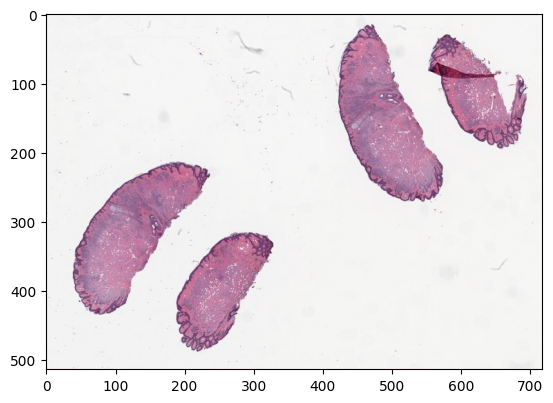

In [30]:
plt.imshow(WSI_IMAGE[0].permute(1, 2, 0)/ 255.0)

## Effect of overlap

Text(0.5, 0.98, 'Effect of overlap (without padding, patch_size=64)')

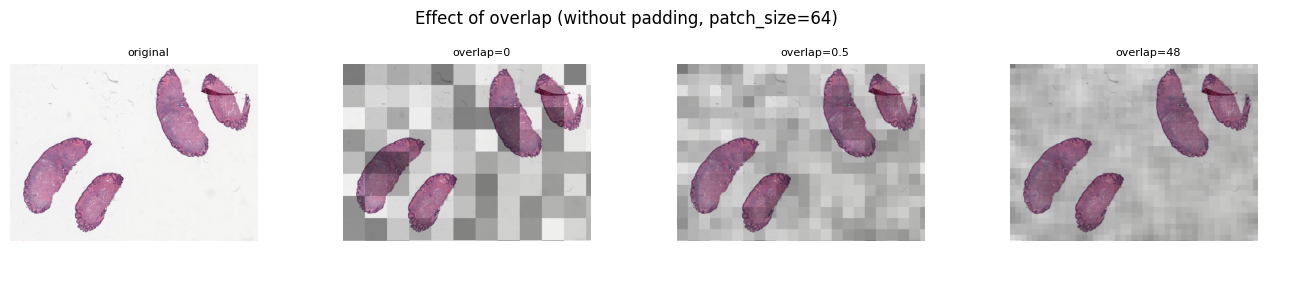

In [31]:
patch_size = 64
overlaps = [0, 0.5, 48]
nrows = 1
ncols = len(overlaps) + 1
figsize = (4 * ncols + 1, 3 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, top=0.8)
wsi_plot(axes[0], WSI_IMAGE)
axes[0].set_title("original", fontsize=8)
for i, overlap in enumerate(overlaps, start=1):
    inferer = PatchInferer(
        splitter=WSISlidingWindowSplitter(patch_size=patch_size, overlap=overlap, reader=WSI_BACKEND, level=wsi_level),
        merger_cls=AvgMerger,
    )
    img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
    wsi_plot(axes[i], img[0])
    axes[i].set_title(f"{overlap=}", fontsize=8)

fig.suptitle(f"Effect of overlap (without padding, {patch_size=})", fontsize=12)

## Effect of padding and matching spatial shape

In [ ]:
match_spatial_shapes = [False, True]
pad_modes = [None, "constant"]
nrows = len(match_spatial_shapes)
ncols = len(pad_modes) + 1
figsize = (4 * ncols, 3 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, hspace=0.15, top=0.9)
wsi_plot(axes[0, 0], WSI_IMAGE)
wsi_plot(axes[1, 0], WSI_IMAGE)
axes[0, 0].set_title("original", fontsize=8)
axes[1, 0].set_title("original", fontsize=8)
for i, match_spatial_shape in enumerate(match_spatial_shapes):
    for j, pad_mode in enumerate(pad_modes, start=1):
        inferer = PatchInferer(
            splitter=WSISlidingWindowSplitter(patch_size=patch_size, pad_mode=pad_mode, reader=WSI_BACKEND, level=6),
            merger_cls=AvgMerger,
            match_spatial_shape=match_spatial_shape,
        )
        img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
        ax = axes[i, j]
        wsi_plot(ax, img[0])
        ax.set_title(f"{pad_mode=}", fontsize=8)
        if j == 1:
            ax.set_ylabel(f"{match_spatial_shape=}", fontsize=8)
fig.suptitle(f" Effect of padding and matching spatial shapes (without overlap, {patch_size=})", fontsize=12)

Text(0.5, 0.98, ' Effect of padding and matching spatial shapes (without overlap, patch_size=64)')

## Effect of filtering patches

Text(0.5, 0.98, 'Patch filtering by a threshold (effect of different patch sizes)')

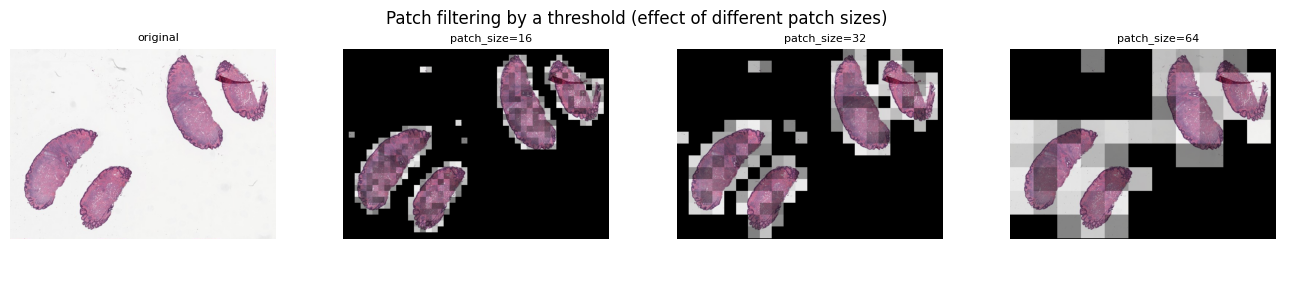

In [33]:
def filter_fn(patch, loc):
    return patch.min() < 130


patch_sizes = [16, 32, 64]
nrows = 1
ncols = len(patch_sizes) + 1
figsize = (4 * ncols + 1, 3 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, top=0.85)
wsi_plot(axes[0], WSI_IMAGE)
axes[0].set_title("original", fontsize=8)
for i, patch_size in enumerate(patch_sizes, start=1):
    inferer = PatchInferer(
        splitter=WSISlidingWindowSplitter(
            patch_size=patch_size, pad_mode=None, filter_fn=filter_fn, reader=WSI_BACKEND, level=wsi_level
        ),
        merger_cls=AvgMerger,
        match_spatial_shape=match_spatial_shape,
    )
    img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
    wsi_plot(axes[i], img[0])
    axes[i].set_title(f"{patch_size=}", fontsize=8)

fig.suptitle("Patch filtering by a threshold (effect of different patch sizes)", fontsize=12)

## Zarr Merger

Zarr is a format for the storage of chunked, compressed, N-dimensional arrays. Zarr data can be stored in any storage system that can be represented as a key-value store, like POSIX file systems, cloud object storage, zip files, and relational and document databases. See https://zarr.readthedocs.io/en/stable/ for more details.

It is particularly useful for storing N-dimensional arrays too large to fit into memory, and here for whole slide images (WSI), where the merged output may not fit into memory and needs to be stored on a file system.

Similar ro any Merger, ZarrAvgMerger can be used simply by plugging it into PatchInferer.


Text(0.5, 0.98, 'Different Mergers (with padding, patch_size=64)')

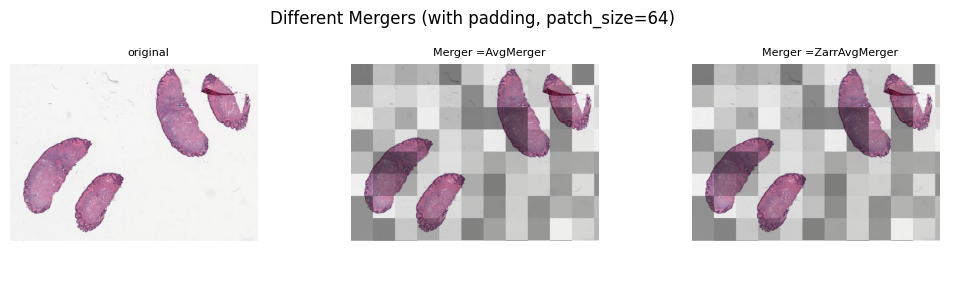

In [35]:

patch_size = 64
mergers = [AvgMerger, ZarrAvgMerger]
nrows = 1
ncols = len(mergers) + 1
figsize = (4 * ncols + 1, 3 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, top=0.8)
wsi_plot(axes[0], WSI_IMAGE)
axes[0].set_title("original", fontsize=8)
for i, merger in enumerate(mergers, start=1):
    inferer = PatchInferer(
        splitter=WSISlidingWindowSplitter(
            patch_size=patch_size, pad_mode="constant", reader=WSI_BACKEND, level=wsi_level
        ),
        merger_cls=merger,
        match_spatial_shape=True,
    )
    img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
    wsi_plot(axes[i], img[0])
    axes[i].set_title(f"Merger ={merger.__name__}", fontsize=8)

fig.suptitle(f"Different Mergers (with padding, {patch_size=})", fontsize=12)

## Zarr array information
Zarr arrays are stored in chunks and each chunk is usually compressed. We can get these information from the zarr array.

In [36]:
zarr_img = img[0]
print("Shape:", zarr_img.shape)
print("Chunk size:", zarr_img.chunks)
print("Number of chunk splits:", zarr_img.cdata_shape)
print("Total number of chunks:", zarr_img.nchunks)
print("Chunk compressor:", zarr_img.compressor)

Shape: (1, 3, 514, 718)
Chunk size: (1, 1, 288, 384)
Number of chunk splits: (1, 3, 2, 2)
Total number of chunks: 12
Chunk compressor: Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)


In [37]:
zarr_path = zarr_img.store.path
print("Zarr image path:", zarr_path)
print("Zarr image directory contents:")
print("\n".join(sorted(os.listdir(zarr_path))))

Zarr image path: /workspace/notebook_monai/merged.zarr
Zarr image directory contents:
.zarray
0.0.0.0
0.0.0.1
0.0.1.0
0.0.1.1
0.1.0.0
0.1.0.1
0.1.1.0
0.1.1.1
0.2.0.0
0.2.0.1
0.2.1.0
0.2.1.1


`.zarray` file contains the metadata of the zarr array, including the shape, dtype, chunks, etc.

In [38]:
!cat merged.zarr/.zarray

{
    "chunks": [
        1,
        1,
        288,
        384
    ],
    "compressor": {
        "blocksize": 0,
        "clevel": 5,
        "cname": "lz4",
        "id": "blosc",
        "shuffle": 1
    },
    "dtype": "<f4",
    "fill_value": null,
    "filters": null,
    "order": "C",
    "shape": [
        1,
        3,
        514,
        718
    ],
    "zarr_format": 2
}

## Use different Zarr storages
Depending on the use case, one might need to use different storages for Zarr arrays to optimize their performance. This can be easily achieved by passing the desired supported Zarr storage to store, value_store, and count_store to change the storage of the final merged output, temporary value accumulator, and temporary sample counter respectively. You can find the list of available storages here: https://zarr.readthedocs.io/en/stable/api/storage.html

In [40]:
inferer = PatchInferer(
    splitter=WSISlidingWindowSplitter(patch_size=patch_size, pad_mode="constant", reader=WSI_BACKEND, level=wsi_level),
    merger_cls=ZarrAvgMerger,
    match_spatial_shape=True,
    store=zarr.storage.ZipStore("merged_output.zip", mode="w"),  # zip file
    value_store=zarr.storage.TempStore(),  # temp file
    count_store=zarr.storage.MemoryStore(),  # memory
)
img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)

## Use different Zarr compressors
Zarr arrays support various compressors, such as Blosc, Zlib, LZ4, etc. For the the full list of available compressors, please check https://numcodecs.readthedocs.io/en/stable/index.html, or run zarr.codec_registry. We can specify the compressor to use when creating the merger separately for each of the Zarr arrays (merged output, value accumulator, and sample counter). By default, the compressor for merged output array is Blosc and the temporary arrays are uncompressed (set to None). You can set any of the available compressors independently for those arrays.

In [41]:
inferer = PatchInferer(
    splitter=WSISlidingWindowSplitter(patch_size=patch_size, pad_mode="constant", reader=WSI_BACKEND, level=wsi_level),
    merger_cls=ZarrAvgMerger,
    match_spatial_shape=True,
    compressor=zarr.codec_registry["lz4"](),
    value_compressor=zarr.codec_registry["zlib"](),
    count_compressor=None,
)
img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)

In [42]:
print("List of available chunk compressors:")
print("\n".join(sorted(zarr.codec_registry.keys())))

List of available chunk compressors:
adler32
astype
base64
bitround
blosc
bz2
categorize
crc32
delta
fixedscaleoffset
gzip
json2
lz4
lzma
msgpack2
n5_wrapper
packbits
pickle
quantize
shuffle
vlen-array
vlen-bytes
vlen-utf8
zlib
zstd


## Multithread buffer for batch sampling
When dealing with whole slide images (WSI), I/O may create a bottleneck for overall speed of the inference pipeline since at each iteration patches are extracted and loaded from file systems or cloud storages, which may have different disk or network latencies. To alleviate this issue, PatchInferer supports having a buffer where a separate thread continuously fill it up with extracted patches. Depending on the I/O latencies, patch sizes, and network inference time this may provide a significant speed up.

In [43]:
patch_size = 256
batch_size = 16
wsi_level = 4

## Single thread without buffer

In [45]:
%%timeit
inferer = PatchInferer(
    splitter=WSISlidingWindowSplitter(patch_size=patch_size, pad_mode="constant", reader=WSI_BACKEND, level=wsi_level),
    merger_cls=ZarrAvgMerger,
    batch_size=batch_size,
)
img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)

1.14 s ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Multi thread with buffer

In [46]:
%%timeit
inferer = PatchInferer(
    splitter=WSISlidingWindowSplitter(patch_size=patch_size, pad_mode="constant", reader=WSI_BACKEND, level=wsi_level),
    merger_cls=ZarrAvgMerger,
    batch_size=batch_size,
    buffer_size=batch_size,
)
img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)

1.32 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Assessment - consider WSI level and patch_size

In [7]:
import numpy as np
from monai.transforms import DivisiblePad
from monai.inferers.utils import sliding_window_inference

import numpy as np

def compute_num_patches_wsi(image_shape_input, patch_size_input, overlap):
    _, _, height, width = image_shape_input 
    image_shape = (height, width)
    
    patch_size = (patch_size_input, patch_size_input) if isinstance(patch_size_input, int) else patch_size_input
    
    if overlap < 1:
        # Overlap is treated as fraction
        steps = [(dim - patch_dim) // (patch_dim * (1 - overlap)) + 1 
                 for dim, patch_dim in zip(image_shape, patch_size)]
    else:
        # Overlap is treated as absolute pixel value
        steps = [dim // (patch_dim - overlap) + 1 
                 for dim, patch_dim in zip(image_shape, patch_size)]

    num_patches_along_dims = [step + 1 if dim % patch_dim != 0 else step 
                              for dim, patch_dim, step in zip(image_shape, patch_size, steps)]

    total_patches = np.prod(num_patches_along_dims)
    return int(total_patches)

In [8]:
# Plot aux function
def wsi_plot(ax, img):
    plot_limit_axis(ax, img, 800, 600)


# Download whole slide images and create file path list
wsi_keys = ["wsi_generic_tiff"]
wsi_urls = ["https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/CMU-1.tiff"]
wsi_hash_vals = ["73a7e89bc15576587c3d68e55d9bf92f09690280166240b48ff4b48230b13bcd"]
WSI_PATH_LIST = []
for key, url, hash in zip(wsi_keys, wsi_urls, wsi_hash_vals):
    path = os.path.join(os.path.abspath("."), f"temp_{key}.tiff")
    download_url(url, path, hash_type="sha256", hash_val=hash)
    WSI_PATH_LIST.append(path)



2023-08-23 05:40:00,350 - INFO - Verified 'temp_wsi_generic_tiff.tiff', sha256: 73a7e89bc15576587c3d68e55d9bf92f09690280166240b48ff4b48230b13bcd.
2023-08-23 05:40:00,351 - INFO - File exists: /workspace/notebook_monai/temp_wsi_generic_tiff.tiff, skipped downloading.


In [9]:
# WSI Reader backend
WSI_BACKEND = "cucim"

# The level at which image should be loaded
wsi_level = 2

# Load input WSI (for plotting purposes only)
WSI_IMAGE = LoadImage(reader=WSIReader, backend=WSI_BACKEND, level=wsi_level, image_only=True)(WSI_PATH_LIST)
WSI_IMAGE = WSI_IMAGE[None, ...]

patch_size= 256 
overlap = 0

num_patches = compute_num_patches_wsi(WSI_IMAGE.shape, patch_size, overlap)
print( f' level : {wsi_level}, {WSI_IMAGE[0][0].size()}, Patch : {patch_size}, Overlap : {overlap} pixel or fraction ---> total number of patches : {num_patches}' )

 level : 2, torch.Size([8228, 11500]), Patch : 256, Overlap : 0 pixel or fraction ---> total number of patches : 1485


In [10]:
import numpy as np
from monai.transforms import DivisiblePad
from monai.inferers.utils import sliding_window_inference
  

def run_inference(inferer, network, filenames, transform=None):
    dataset = Dataset(filenames, transform=transform)
    outputs = []
    for inputs in DataLoader(dataset):
        out = inferer(inputs, network)
        print(out.shape)
        #outputs.append(out)
        plt.imshow(out[0].permute(1, 2, 0)/ 255.0)


torch.Size([3, 8228, 11500])


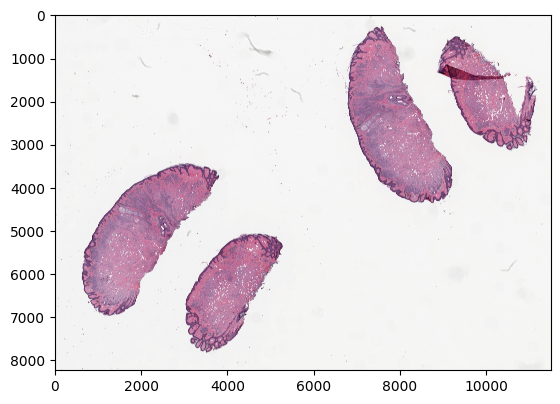

In [11]:
print(WSI_IMAGE[0].shape)
plt.imshow(WSI_IMAGE[0].permute(1, 2, 0)/ 255.0)
plt.show()

torch.Size([1, 3, 8228, 11500])


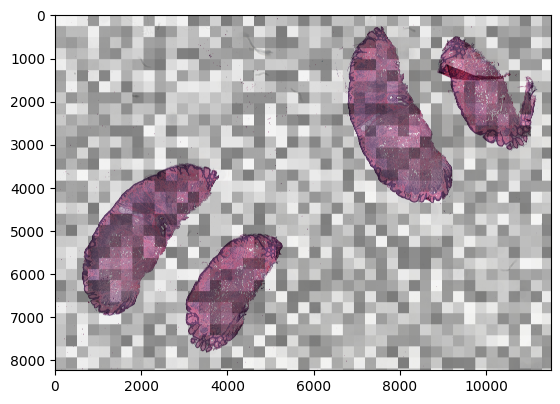

In [12]:
inferer = PatchInferer(
    splitter=WSISlidingWindowSplitter(patch_size=patch_size, overlap=overlap, reader=WSI_BACKEND, level=wsi_level),
    merger_cls=AvgMerger,
)

run_inference(inferer, network_random_brightness, WSI_PATH_LIST)


torch.Size([1, 3, 8228, 11500])


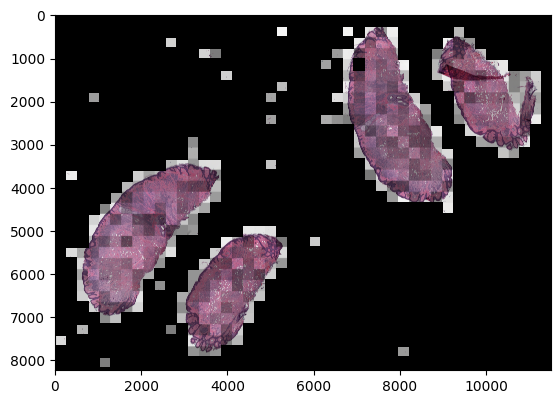

In [14]:
def filter_fn(patch, loc):
    return patch.min() < 10

match_spatial_shape=True
inferer = PatchInferer(
    splitter=WSISlidingWindowSplitter(patch_size=patch_size,pad_mode=None, filter_fn=filter_fn, overlap=overlap, reader=WSI_BACKEND, level=wsi_level),
    merger_cls=AvgMerger,
    match_spatial_shape=match_spatial_shape,
)

run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
